## M6 - W6 Assignment: Time Series Analysis

Working with time series is an important skill for a data scientist. Many of the datasets you may need to work with are either time series or have some form of time element to them. When you think about financial markets, transactions happening in stores, banks, ecommerce, orders and workload forecasting– these all are examples of time series problems.

In this assignment, I will work with forecasting sales in retail stores using the Retail Data Analytics data from Kaggle here:

https://www.kaggle.com/manjeetsingh/retaildataset

For this assignment I will:

1) Explore the data and perform visualizations and look for some seasonality in the target and assess what kind

2) Train a model (or models) that predicts the weekly sales in a department store  

3) Evaluate the model I have trained and reason about how the store managers can use my forecast to better anticipate sales fluctuations.

In [22]:
#Import necessary modules
import pandas as pd
import numpy as np
from functools import reduce
from pylab import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error

In [2]:
#Import the datasets
sales = pd.read_csv('sales data-set.csv')
features = pd.read_csv('Features data set.csv')
stores = pd.read_csv('stores data-set.csv')

print(sales.head())
print(features.head())
print(stores.head())

   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  05/02/2010      24924.50      False
1      1     1  12/02/2010      46039.49       True
2      1     1  19/02/2010      41595.55      False
3      1     1  26/02/2010      19403.54      False
4      1     1  05/03/2010      21827.90      False
   Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  05/02/2010        42.31       2.572        NaN        NaN   
1      1  12/02/2010        38.51       2.548        NaN        NaN   
2      1  19/02/2010        39.93       2.514        NaN        NaN   
3      1  26/02/2010        46.63       2.561        NaN        NaN   
4      1  05/03/2010        46.50       2.625        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN        NaN  211.096358         8.106      False  
1        NaN        NaN        NaN  211.242170         8.106       True  
2        NaN        NaN        NaN  211

In [3]:
#Let's merge the three datasets so we have one to work with
dfs = [sales, features, stores]
df_merged = reduce(lambda left,right: pd.merge(left,right), dfs)

#Next let's remove 'Type' column as it is not too clear what these relate to
df_merged.drop(['Type'], axis=1, inplace=True)
print(df_merged.head())

   Store  Dept        Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1  05/02/2010      24924.50      False        42.31       2.572   
1      1     2  05/02/2010      50605.27      False        42.31       2.572   
2      1     3  05/02/2010      13740.12      False        42.31       2.572   
3      1     4  05/02/2010      39954.04      False        42.31       2.572   
4      1     5  05/02/2010      32229.38      False        42.31       2.572   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        NaN        NaN        NaN        NaN        NaN  211.096358   
1        NaN        NaN        NaN        NaN        NaN  211.096358   
2        NaN        NaN        NaN        NaN        NaN  211.096358   
3        NaN        NaN        NaN        NaN        NaN  211.096358   
4        NaN        NaN        NaN        NaN        NaN  211.096358   

   Unemployment    Size  
0         8.106  151315  
1         8.106  151315  
2       

In [4]:
#EDA
print(df_merged.info(), '\n')
print(df_merged.describe(), '\n')
print('There are', df_merged['Dept'].nunique(), 'departments.')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   MarkDown1     150681 non-null  float64
 8   MarkDown2     111248 non-null  float64
 9   MarkDown3     137091 non-null  float64
 10  MarkDown4     134967 non-null  float64
 11  MarkDown5     151432 non-null  float64
 12  CPI           421570 non-null  float64
 13  Unemployment  421570 non-null  float64
 14  Size          421570 non-null  int64  
dtypes: bool(1), float64(10), int64(3), object(1)
memory usage: 48.6+ MB
None 

               Store           Dept   Weekly_Sales    Tempera

There are 421570 rows and 15 columns. The `MarkDown` columns contain a number of missing values, and `Weekly_Sales` contains a negative minimum which could have come from a refunded sale.

There are 45 stores ranging in size from 34,875 to 219,622 though no unit is given. Reading the codebook in Kaggle, `Unemployment` is the unemployment rate, `CPI` is the Consumer Price Index.

The variance in the min and max `Fuel Price` is explained by this report from the US Energy Information Administration so I will not investigate this further:

https://bit.ly/3e1OgqO

Given the missing values in the `MarkDown` columns and that I do not have enough information on what the values and different columns mean, I will remove them.

In [5]:
#Remove MarkDown columns
df2 = df_merged.drop(['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], axis=1)

#Let's set the 'Date' to be the index

df2['Date'] = pd.to_datetime(df2['Date'], format='%d/%m/%Y')
df2.set_index('Date', inplace=True)
print('Date from: ', df2.index.min().strftime('%e/%b/%Y'),  '\n')
print('Date until: ', df2.index.max().strftime('%e/%b/%Y'))

Date from:   5/Feb/2010 

Date until:  26/Oct/2012


Next let's look at weekly sales and see if there are any trends we are able to identify.

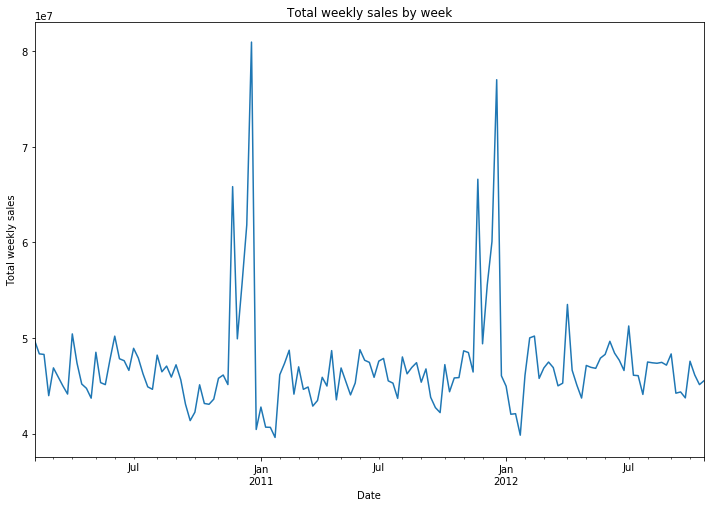

In [6]:
_ = df2.groupby(df2.index).sum()['Weekly_Sales'].plot(figsize=(12,8),\
                                                      title='Total weekly sales by week')
_ = plt.ylabel('Total weekly sales')
_ = plt.xlabel('Date')

plt.show()

It can be seen from the above data that the week before Super Bowl there are higher sales than all of January, as well as Super Bowl week (early Feb) itself. January itself shows an annual slump in sales.
Labor Day (early May) shows no influence on sales. Thanksgiving (late November) gives a large spike in sales. Also the week before NYE sees the largest increase and could be attributed to Christmas.

Observations:

* There is a yearly cycle  
* There does not appear to be an increasing trend of sales over time  
* There appears to be seasonality to the sales for each year  
* There do not appear to be any obvious outliers  
* The seasonality suggests that sales are non-stationary.  

Next, let's split out the years individually.

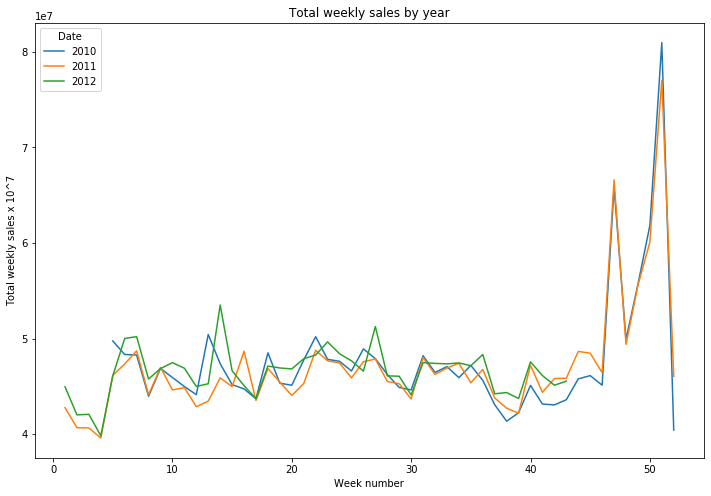

In [7]:
df_pivot = pd.pivot_table(df2, index=df2.index.week, columns=df2.index.year,\
                          values='Weekly_Sales', aggfunc='sum')

_ = df_pivot.plot(figsize=(12,8), title='Total weekly sales by year')
_ = plt.ylabel('Total weekly sales x 10^7')
_ = plt.xlabel('Week number')

plt.show()

The sales seem to be pretty consistent year on year for total sales by week number with some differences in April and early July.

Next let's look at boxplots of the data and see what we can observe.

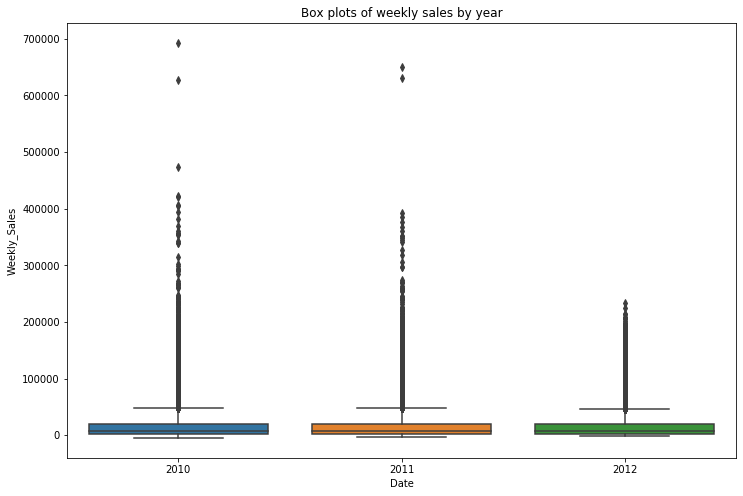

In [8]:
_ = plt.figure(figsize=(12,8))
_ = sns.boxplot(df2.index.year, df2['Weekly_Sales']).set_title('Box plots of weekly sales by year')
plt.show()

From the box plots we can observe:

* The median values for each year appear to remain stable
* The spread of the data (blue boxes) appear reasonably stable
* There are outliers each year and may be related to sales during seasonal cycle
  - 2012 does not have data into Thanksgiving and Christmas, so does not have the same large outliers

Next let's look at correlations in the data.

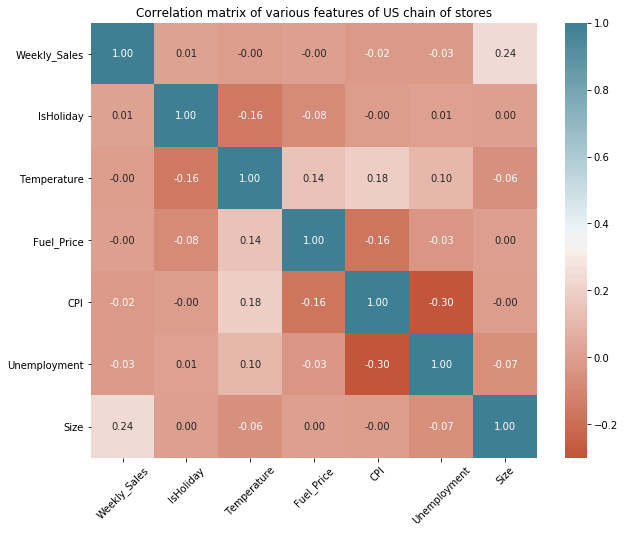

In [9]:
df_corr = df2.drop(['Store', 'Dept'], axis=1).corr()
_ = plt.figure(figsize=(10,8))
_ = sns.heatmap(df_corr, cmap=sns.diverging_palette(20, 220, n=200), annot=True, fmt='0.2f')
_ = plt.title('Correlation matrix of various features of US chain of stores')
_ = plt.xticks(rotation=45)
plt.show()

I dropped `Store` and `Dept` as these are identifiers so will not give any helpful correlation information.

There is a noticeable negative correlation between CPI and unemployment, meaning as one goes up the other goes down which reflects that when the economy is doing well people spend more and unemployment drops. In addition CPI is weakly negatively correlated to Fuel Prices, again meaning if CPI goes up, fuel prices go down though there are many other factors at play with fuel prices. CPI also appears to increase when the weather is warmer.

Weekly sales are positively correlated with store size, which makes sense - the bigger the store, the more sales.

Holidays are negatively correlated to temperature, suggesting more holidays occur in the colder months - this is in line with Super Bowl, Thanksgiving, and NYE all occuring during winter or late autumn.

Next let's decompose our data to see which trends can be observed.

There are 52 weeks in the year.


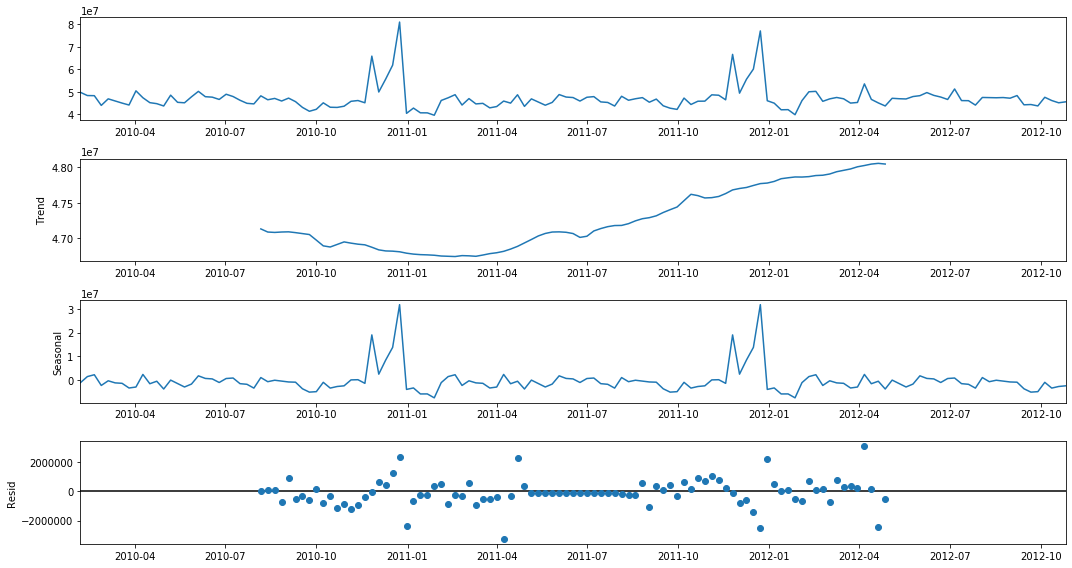

In [10]:
#Create weekly sales aggregated by week
pivot_sales = pd.pivot_table(df2, index=df2.index, \
                          values='Weekly_Sales', aggfunc='sum')

#Check for weeks in year, incase 53 are used
print('There are', df_pivot.index.nunique(), 'weeks in the year.')

result = seasonal_decompose(pivot_sales, period=52)
rcParams['figure.figsize'] = 15, 8
_ = result.plot()
plt.show()

The data shows a strong annual seasonality, with a downward and then upward trend. The residuals appear to be related to Thanksgiving, Christmas and in May which could be Memorial Day, or a sales event at the store. This would need further investigation.

### SARIMA

SARIMA is used for non-stationary series such as ours. This model can identify trend and seasonality, which makes it relevant to our data which shows a strong seasonality.

The models notation is `SARIMA(p, d, q).(P,D,Q)m`. p, d, q account for seasonality, trend, and noise in data, and m for the period of seasonality (52 in our case as it is annual seasonality on weekly data).

First let's look at AIC to determine the best parameters for the SARIMA model.

The AIC (Akaike information criterion) is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. The lower the AIC value the better. 

In [45]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

best_param, best_seasonal_param, best_AIC = None, None, float("inf")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(pivot_sales, order=param,\
                                            seasonal_order=param_seasonal,\
                                            enforce_stationarity=False, enforce_invertibility=False)
            results = mod.fit()
            if results.aic < best_AIC:
                best_AIC, best_param, best_seasonal_param = results.aic, param, param_seasonal
            
        except: 
            continue
print('SARIMAX{}x{} - AIC:{}'.format(best_param, best_seasonal_param, best_AIC))

SARIMAX(0, 1, 1)x(0, 1, 1, 52) - AIC:1144.270110188994


Running the above using AIC as the test we can see that the optimal option for our model is `SARIMAX(0,1,1)(0,1,1)52` with `AIC` 1144.27.

In [46]:
model = SARIMAX(pivot_sales, order=(0, 1, 1), \
                seasonal_order=(0, 1, 1, 52), \
                enforce_stationarity=False,enforce_invertibility=False)
results2 = model.fit()

Next let's run a prediction using the model and see how they compare to the actual sales.

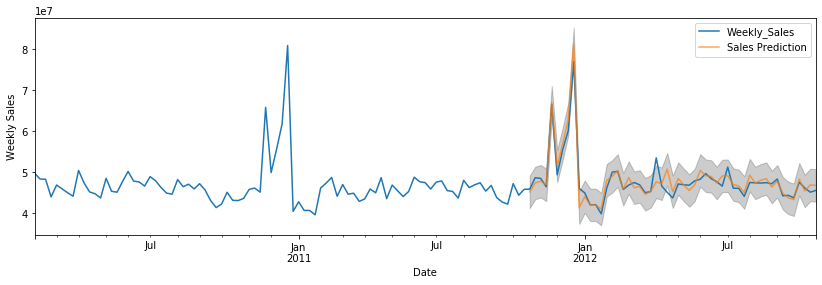

In [47]:
#Let's predict a year's worth of sales
sales_pred = results2.get_prediction(start=pd.to_datetime('2011-10-28'), dynamic=False)

#Confidence internal
pred_ci = sales_pred.conf_int()

#Plot actual vs prediction
ax = pivot_sales['2010':].plot(label='Actual Sales')
sales_pred.predicted_mean.plot(ax=ax, label='Sales Prediction', alpha=.7, figsize=(14, 4))

#Show the confidence interval
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Weekly Sales')
plt.legend()
plt.show()

The prediction looks like a good match for the actual data.

Next's let's check the accuracy using RMSE.

In [55]:
sales_forecasted = sales_pred.predicted_mean
sales_actual = pivot_sales['2011-10-28':]

#Calculate MSE and RMSE
mse = mean_squared_error(sales_actual, sales_forecasted)
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error is 1812341.2


Let's see how the model fares against a `SARIMAX(0,0,0)(0,0,0)52` model to see how it compares for RMSE.

In [57]:
model000 = SARIMAX(pivot_sales, order=(0, 0, 0), \
                seasonal_order=(0, 0, 0, 52), \
                enforce_stationarity=False,enforce_invertibility=False)
results3 = model000.fit()
pred000 = results3.get_prediction(start=pd.to_datetime('2011-10-28'), dynamic=False).predicted_mean
mse000 = mean_squared_error(sales_actual, pred000)

print('The Root Mean Squared Error for SARIMAX(0,0,0)(0,0,0)52 is {}'.format(round(np.sqrt(mse000), 2)))

The Root Mean Squared Error for SARIMAX(0,0,0)(0,0,0)52 is 48347652.08


On inspection we can see that our model has a much lower RMSE.

Finally, let's forecast the values for the next 12 months.

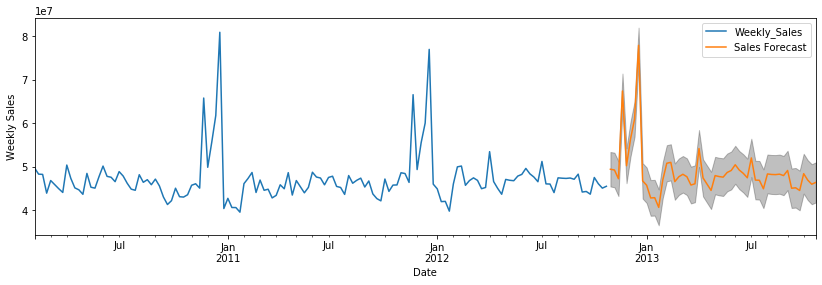

In [49]:
forecast_sales = results2.get_forecast(steps=52)
forecast_ci = forecast_sales.conf_int()
ax = pivot_sales.plot(figsize=(14, 4), label='Actual Sales')
forecast_sales.predicted_mean.plot(ax=ax, label='Sales Forecast')
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Weekly Sales')
ax.legend()
plt.show()

This model follows the same seasonality as previous years and can be used by store managers to predict sales throughout the year to help anticipate any slumps, or sharp increases in sales. Given this, store managers will be able to adjust staffing and in store offers and discounts accordingly.

### Further work

I would like to also test with further parameters for `p`, `d`, and `q` as well as other models which also look at the other features in the original dataset such as `CPI` and `Store Size` to help predict for individual stores.